### simple MLP demo

In [57]:
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [58]:
def auc_score(y_true, y_score):
    """Does not permit ties"""
    y_true, y_score = np.array(y_true).astype(bool), np.array(y_score).astype(float)
    return (y_score[y_true] > y_score[~y_true].reshape(-1, 1)).mean()

auc_score([0, 0, 1, 1], [.1, .3, .5, .7]), auc_score([0, 1, 1, 0], [.1, .3, .5, .7]), \
    auc_score([1, 1, 0, 0], [.1, .3, .5, .7])

(1.0, 0.5, 0.0)

0.4


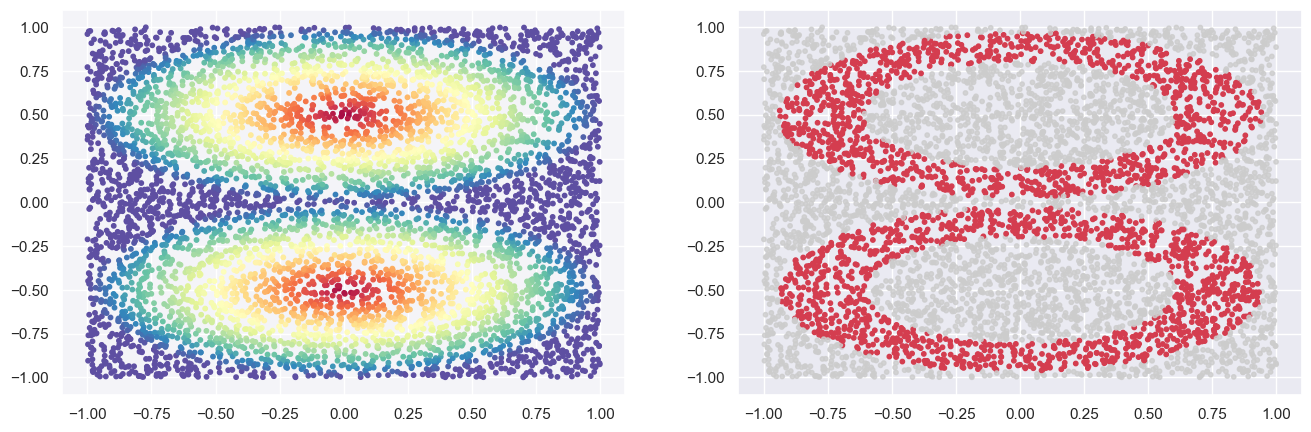

In [59]:
m, n = 6000, 2
np.random.seed(123)
X = 2 * np.random.random((m, n)) - 1
x0, x1 = X.T
y_true_score = np.sqrt(x0 ** 2 + 4 * (np.abs(x1) - .5) ** 2)
t1, t2 = np.percentile(y_true_score, 30), np.percentile(y_true_score, 70)
y = (t1 < y_true_score) & (y_true_score < t2)  # * .5 + .5
print(y.mean())

cmap = sns.color_palette("Spectral", as_cmap=True)
cmap2 = np.array([(.8, .8, .8, .8), cmap(.1)])
_, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].scatter(X[:, 0], X[:, 1], s=10, color=cmap(y_true_score))
axs[1].scatter(X[:, 0], X[:, 1], s=10, color=cmap2[y.astype(int)])
axs[0].patch.set_alpha(0.5)

In [60]:
# y_t.dtype

In [70]:
dtype = torch.float
# device = "cpu" 
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
torch.set_default_device(device)
print(f"Using {device} device")

Using mps device


In [79]:
g = torch.Generator(device=device).manual_seed(123) # for reproducibility
X_t, y_t = torch.Tensor(X), torch.Tensor(y.reshape(-1, 1)).float()
X_t, y_t = X_t.to(device), y_t.to(device)

m1, m2, m3 = X.shape[1], 12, 1  

a1 = torch.randn((m1, m2), generator=g, dtype=dtype, requires_grad=True)  # weights
b1 = torch.randn(m2, generator=g, dtype=dtype, requires_grad=True)  # bias
a2 = torch.randn((m2, m3), generator=g, dtype=dtype, requires_grad=True)  # weights
b2 = torch.randn(m3, generator=g, dtype=dtype, requires_grad=True)  # bias

parameters = [a1, b1, a2, b2]
for p in parameters:
    p.require_grad = True

In [80]:
# forward pass
h = (X_t @ a1 + b1).tanh()
z = h @ a2 + b2
y_score = z.sigmoid()
loss = -1. / m * (y_t * y_score.log() + (1 - y_t) * (1 - y_score).log()).sum()
loss

tensor(1.1405, device='mps:0', grad_fn=<MulBackward0>)

In [81]:
# batch_size = 32
# batch_i = 3
# X_batch = X_t[batch_i * batch_size:(batch_i + 1) * batch_size]
# X_batch

In [82]:
learning_rate = 1
n_epochs = int(2e4)  # passes through full data set
n_prints = 10
# batch_size = 32

for i in range(n_epochs + 1):
      
    # forward pass
    h = (X_t @ a1 + b1).tanh()
    z = h @ a2 + b2
    y_score = z.sigmoid()
    loss = -1. / m * (y_t * y_score.log() + (1 - y_t) * (1 - y_score).log()).sum()

    # backward pass
    for p in parameters:
        p.grad = None  # zero grad

    loss.backward()

    # update
    with torch.no_grad():    
        for p in parameters:
            p.data -= learning_rate * p.grad

    if i % (n_epochs // n_prints) == 0:
        auc = auc_score(y, y_score.cpu().data.reshape(-1))
        acc = (y == np.array(y_score.cpu().data.reshape(-1) > .5)).mean()
        print("%5s  loss %.4f  auc %.4f  acc %.4f" % (i, loss.data, auc, acc))

    0  loss 1.1405  auc 0.5115  acc 0.4250
 2000  loss 0.5276  auc 0.7948  acc 0.7162
 4000  loss 0.4999  auc 0.8177  acc 0.7407
 6000  loss 0.3811  auc 0.9150  acc 0.8202
 8000  loss 0.3730  auc 0.9203  acc 0.8333
10000  loss 0.3707  auc 0.9225  acc 0.8355
12000  loss 0.3684  auc 0.9245  acc 0.8432
14000  loss 0.3620  auc 0.9310  acc 0.8638
16000  loss 0.3526  auc 0.9343  acc 0.8615
18000  loss 0.3467  auc 0.9366  acc 0.8660
20000  loss 0.3445  auc 0.9379  acc 0.8682


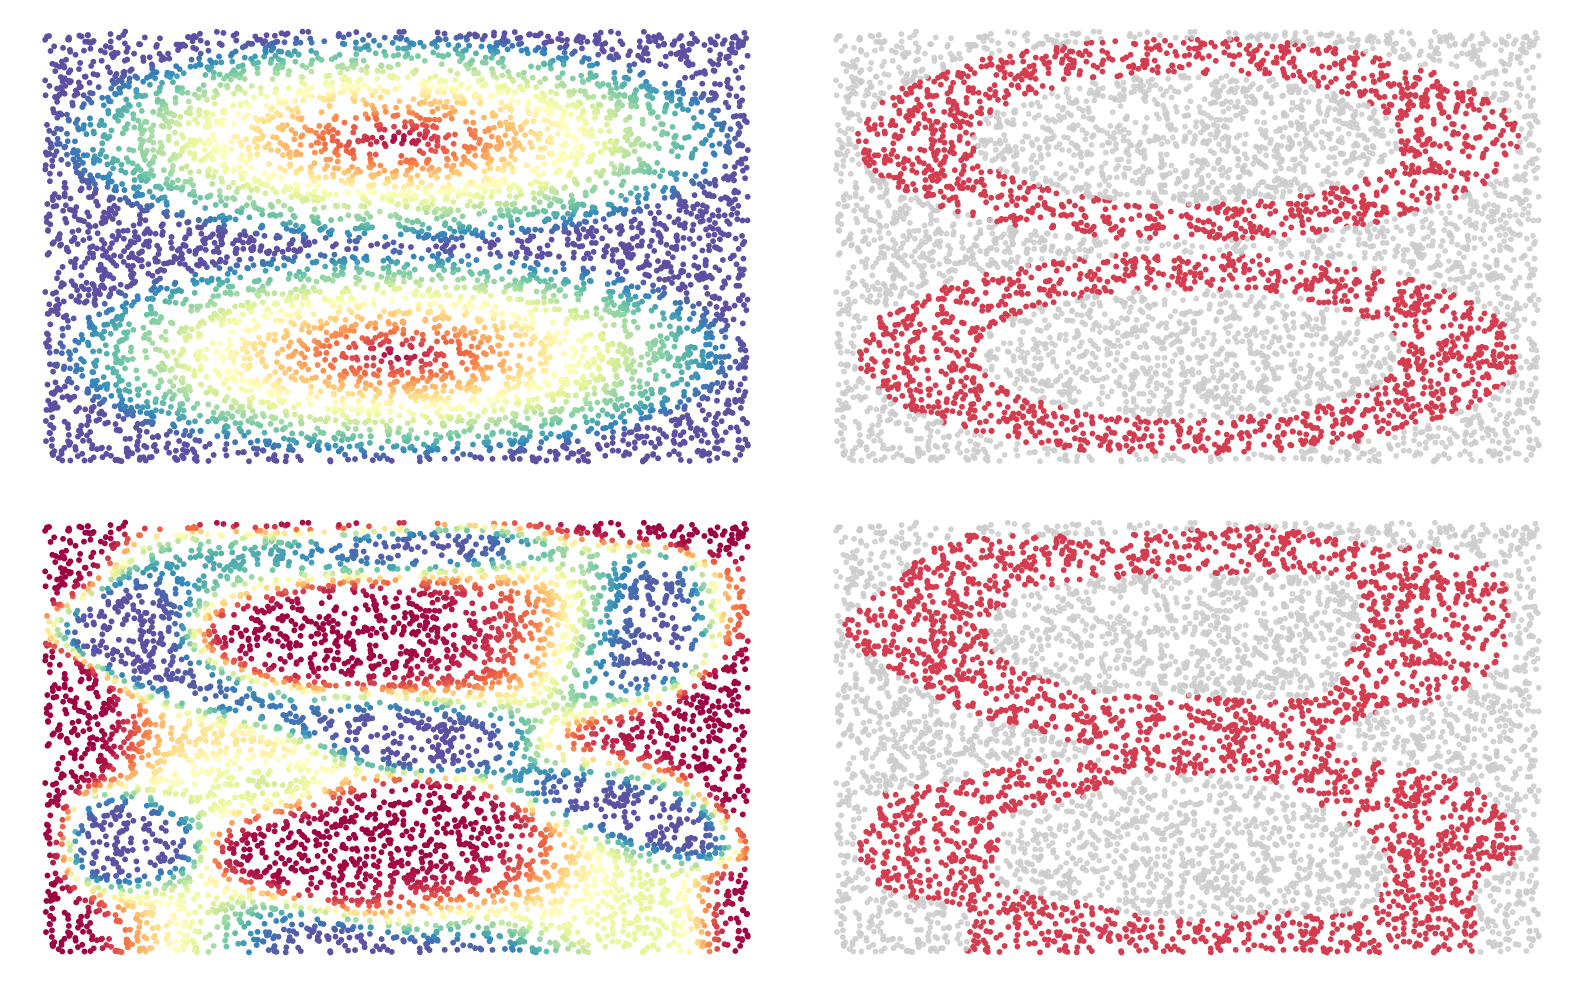

In [83]:
_, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].scatter(X[:, 0], X[:, 1], s=10, color=cmap(y_true_score))
axs[0, 1].scatter(X[:, 0], X[:, 1], s=10, color=cmap2[y.astype(int)])

y_pred = np.array(y_score.cpu().data.reshape(-1) > .5)
axs[1, 0].scatter(X[:, 0], X[:, 1], s=10, color=cmap(y_score.cpu().data.reshape(-1)))
axs[1, 1].scatter(X[:, 0], X[:, 1], s=10, color=cmap2[y_pred.astype(int)])


for ax in axs.reshape(-1):
    ax.set_xticks([]), ax.set_yticks([]), ax.patch.set_alpha(0.0)
plt.tight_layout()